/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


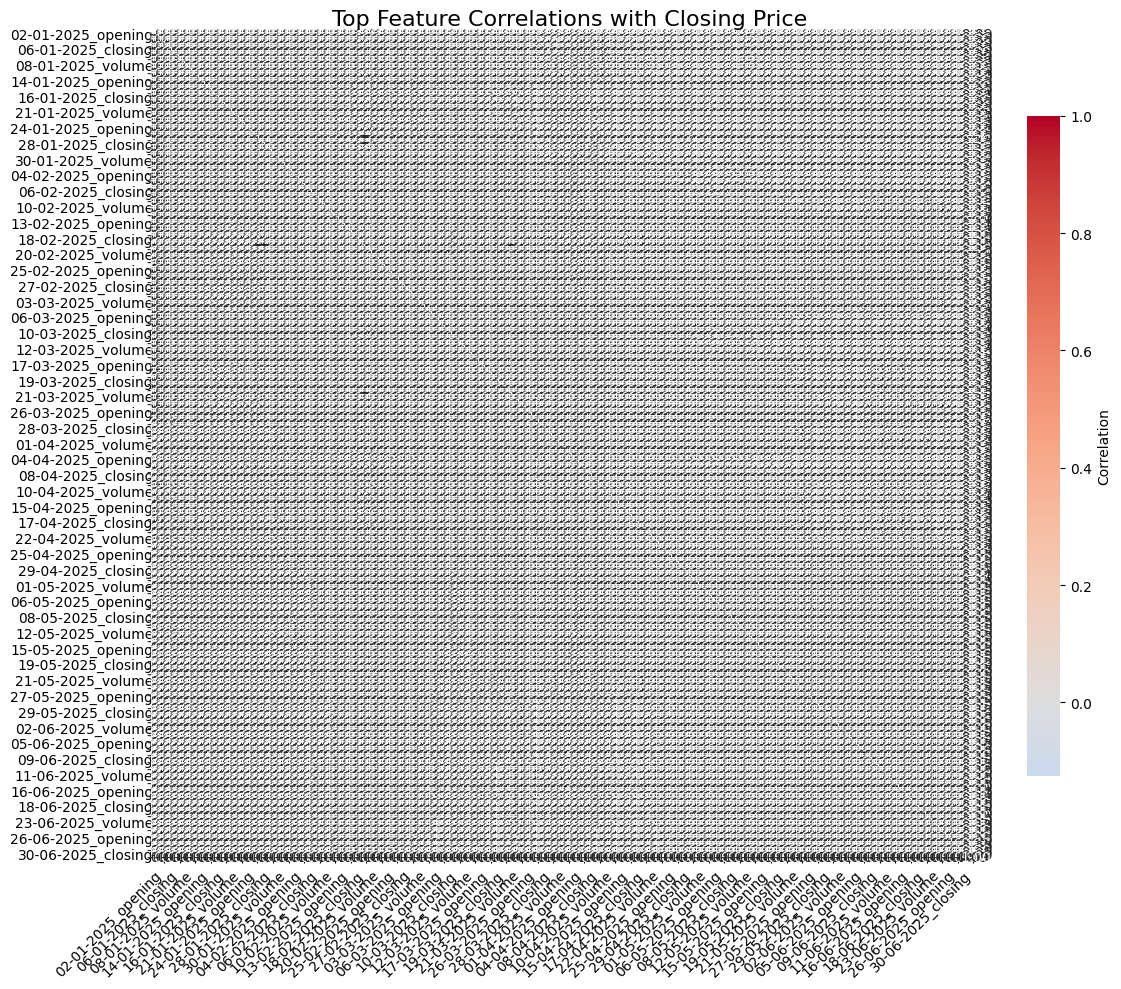

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # plotting

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# load dataset
df = pd.read_csv("/kaggle/input/s-and-p-500-stocks-trade-data-for-first-6-month-2025/sp500_2025_h1.csv")

# select numeric columns only
numeric_df = df.select_dtypes(include='number')

# compute correlation matrix
corr_matrix = numeric_df.corr()

# focus on correlations with Closig Price 
if 'Closing Price' in corr_matrix.columns: 
    top_corr = corr_matrix['Closing Price'].sort_values(ascending=False)
    top_feature = top_corr.index
    corr_matrix_top = corr_matrix_top.replace([np.inf, -np.inf], np.nan)
    corr_matrix_top = corr_matrix_top.fillna(0)
    corr_matrix_top = corr_matrix.loc[top_features, top_features]
else: 
    corr_matrix_top = corr_matrix
    

# plot heatmap 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_top, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            center=0, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.8, "label": "Correlation"})
plt.title("Top Feature Correlations with Closing Price", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("corr_closing_price.png")
plt.show()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder 

class SP500ETLPipeline: 
    def __init__(self, df): 
        self.df = df.copy()
        self.scaler = StandardScaler()
        self.label_encoders = {}

    def reshape_wide_to_long(self): 
        """
        Kindly note: This function Converts wide-format repeated columns (Opening, Closing, Volume per date)
        into long format: one row per company per date. 
        """

        # identify repeated columns
        value_vars = [col for col in self.df.columns if col not in ['company_name', 'ticker']]
        long_df = pd.melt(self.df, id_vars=['company_name', 'ticker'], 
                          value_vars=value_vars,
                          var_name='variable', value_name='value')

        # extract feature type and date from column names
        # long_df['Feature'] = long_df['variable'].str.extract(r'([A-Za-z ]+)')
        # long_df['Date'] = long_df['variable'].str.extract(r'(\d{4}-\d{2}-\d{2})')

        # split variable into Date and Feature
        long_df[['Date', 'Feature']] = long_df['variable'].str.split('_', expand=True)

        # pivot to get Opening, Closing, Volume as seperate columns
        self.df = long_df.pivot_table(index=['company_name', 'ticker', 'Date'], 
                                      columns='Feature', values='value').reset_index()
        
        
        

        